# Train Models

In [78]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import shap
shap.initjs()

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

In [79]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Currently, when `keep_empty_feature=False` and `strategy=\"constant\"`",
    category=FutureWarning,
    module=r"sklearn\.impute\._base",
)

In [80]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [81]:
# baseline
full_csv = pd.read_csv('../data/processed/s9_final.csv')
full_csv = full_csv.copy()

print(f'majority class: {int(np.argmax(full_csv['outcome']))}')

majority class: 0


In [82]:
# the target var
y = full_csv['outcome']
X = full_csv.drop(columns=['outcome'])


print(X.shape)
print(y.shape)

(211, 571)
(211,)


In [83]:
# collect features

# splitting by numeric and cat features. note: all features with numbers are num in this dataset
def split_num_cat_by_value(X: pd.DataFrame):
    coerced = X.apply(lambda s: pd.to_numeric(s, errors="coerce"))
    is_numeric_col = coerced.notna().sum(axis=0).eq(X.notna().sum(axis=0))

    num_ftrs = X.columns[is_numeric_col].tolist()
    cat_ftrs = X.columns[~is_numeric_col].tolist()
    
    return num_ftrs, cat_ftrs

num_ftrs, cat_ftrs = split_num_cat_by_value(X)

# no ordinal ftrs in this dataset
ordinal_ftrs = []
ordinal_cats = []

# no overlapping features
assert set(num_ftrs) & set(cat_ftrs) == set()

In [84]:
test = X.drop(columns=cat_ftrs)
cols_with_missing = test.columns[test.isna().any()].tolist()

print(cols_with_missing)

bad_rows = test.index[test[cols_with_missing].isna().any(axis=1)]
print("num na rows:", len(bad_rows))
print("na row indices:", bad_rows.tolist()[:50])

['ttk_ds1_to_atk_str']
num na rows: 3
na row indices: [38, 39, 40]


In [85]:
# fill any non-attacking unit with high ttk
X["ttk_ds1_to_atk_str"] = X["ttk_ds1_to_atk_str"].fillna(1e6)

len(X.columns)

571

In [86]:
print(X.shape)
print(y.shape)

(211, 571)
(211,)


In [87]:
random_states = [0,1,2,3,5]
#,8,9,42,69,100

<h3>Baselines</h3>

In [128]:
def eval_from_proba(y_true, y_proba, thr=0.5):
    y_hat = (y_proba >= thr).astype(int)
    
    return {
        "acc": accuracy_score(y_true, y_hat),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
    }

def baseline_over_seeds(X, y, random_states, test_size=0.1):
    rows = []

    for r in random_states:
        _, _, y_other, y_test = train_test_split(X, y, test_size=test_size, random_state=r, stratify=y)
        p = float(np.mean(y_other))
        y_proba = np.full(shape=len(y_test), fill_value=p, dtype=float)
        m = eval_from_proba(y_test, y_proba)

        rows.append({"seed": r, "cv_acc": 1-p, **{f"test_{k}": v for k, v in m.items()}}) # here majority is class 0
    
    out = pd.DataFrame(rows)
    summary = out.drop(columns=["seed"]).agg(["mean", "std"])
    return out, summary

baseline_df, baseline_summary = baseline_over_seeds(X, y, random_states)
print(baseline_summary)
baseline_summary.to_csv('../results/baseline.csv')

        cv_acc  test_acc  test_roc_auc  test_precision  test_recall  test_f1
mean  0.502646       0.5           0.5             0.0          0.0      0.0
std   0.000000       0.0           0.0             0.0          0.0      0.0


for each random state:
    initiate the parameter grid for these five models
    - logistic regression, elastic net
    - random forest, svc, xgboost, knn
    train 5 models over this random state

In [89]:
# make the preprocessors for data
def make_preprocessor(num_ftrs, cat_ftrs) -> ColumnTransformer:
    # define pipelines
    numeric_transformer = Pipeline(steps=[
        ('scalar', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        # fill nans with missing, treating as separate cat
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])

In [90]:
for r in random_states:
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.1, random_state=r, stratify=y)

    prep = make_preprocessor(num_ftrs, cat_ftrs)
    prep.fit(X_other)

    Xt_other = prep.transform(X_other)
    Xt_test  = prep.transform(X_test)

    print(Xt_other.shape)
    print(Xt_test.shape)

    assert np.isnan(Xt_other).any() == False
    assert np.isnan(Xt_test).any() == False

    print('\n')

(189, 814)
(22, 814)


(189, 820)
(22, 820)


(189, 818)
(22, 818)


(189, 813)
(22, 813)


(189, 815)
(22, 815)




<h3>Make pipelines and grids</h3>

In [91]:
# function to make models n grids
def make_models_and_grids(random_state: int) -> tuple:
    models = {
        'logreg_l2': LogisticRegression(max_iter=10000, random_state=random_state, penalty='l2', solver='lbfgs'),
        'logreg_elastic': LogisticRegression(max_iter=10000, random_state=random_state, penalty='elasticnet', solver='saga', n_jobs=3),
        'rfc': RandomForestClassifier(n_jobs=3, random_state=random_state, n_estimators=500),
        'svc': SVC(kernel='rbf', probability=True, random_state=random_state),
        'knn': KNeighborsClassifier(n_jobs=3),
        'xgb': xgb.XGBClassifier(random_state=random_state, eval_metric='logloss',tree_method='hist',n_jobs=3)}

    grids = {
        "logreg_l2": {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__class_weight": [None, "balanced"],
        },

        "logreg_elastic": {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__l1_ratio": [0.1, 0.5, 0.9],
            "clf__class_weight": [None, "balanced"],
        },

        "rfc": {
            "clf__n_estimators": [300, 800],
            "clf__max_depth": [None, 5, 10],
            "clf__min_samples_leaf": [1, 3, 5, 8],
            "clf__max_features": ["sqrt", 0.25, 0.5],
            "clf__class_weight": [None, "balanced"],
        },

        "svc": {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", 0.01, 0.1],
            "clf__class_weight": [None, "balanced"],
        },

        "knn": {
            "clf__n_neighbors": [3, 5, 9, 15],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2],
        },

        "xgb": {
            "clf__n_estimators": [200, 600],
            "clf__max_depth": [2, 3, 5],
            "clf__learning_rate": [0.03, 0.1],
            "clf__subsample": [0.6, 1.0],
            "clf__colsample_bytree": [0.6, 1.0],
            "clf__reg_lambda": [1.0, 10.0],
        },
    }

    return models, grids

In [92]:
# return 1d array of pos class
def get_cont_scores(fitted_pipeline, X):
    if hasattr(fitted_pipeline, "decision_function"):
        scores = fitted_pipeline.decision_function(X)
        return np.asarray(scores).ravel()

    if hasattr(fitted_pipeline, "predict_proba"):
        proba = fitted_pipeline.predict_proba(X)
        return np.asarray(proba)[:, 1].ravel()

In [93]:
# run a model over all randoms
def one_model(X, y, model_n: str, num_ftrs, cat_ftrs, random_states, test_size=0.1, scoring='accuracy'):
    rows = []

    out_dir = Path("../results/grid_pipe")
    out_dir.mkdir(parents=True, exist_ok=True)

    for r in random_states:
        models, grids = make_models_and_grids(r)
        base_model = models[model_n]
        param_grid = grids[model_n]
        
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=test_size, random_state=r, stratify=y)

        preprocessor = make_preprocessor(num_ftrs, cat_ftrs)

        pipe = Pipeline(steps=[
            ('prep', preprocessor),
            ('clf', clone(base_model)),
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=r)

        gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1, refit=True)
        gs.fit(X_other, y_other)

        # evaluate on held out test
        best_pipe = gs.best_estimator_
        y_pred = best_pipe.predict(X_test)
        scores = get_cont_scores(best_pipe, X_test)
        
        # label metrics
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)
        roc_auc_s = roc_auc_score(y_test, scores)

        rows.append({
            "seed": r,
            'model': model_n,
            'best_cv_acc': gs.best_score_,
            'test_acc': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_s,
            'best_params': gs.best_params_,
            "test_precision": prec,
            "test_recall": rec,
            "test_f1": f1})
        
        # save grid info
        pd.DataFrame(gs.cv_results_).to_csv(out_dir / f"{model_n}_seed{r}_cv_results.csv", index=False)
        with open(out_dir / f"{model_n}_seed{r}_best_pipe.pkl", "wb") as f:
            pickle.dump(best_pipe, f)
        with open(out_dir / f"{model_n}_seed{r}_X_test.pkl", "wb") as f:
            pickle.dump(X_test, f)
        with open(out_dir / f"{model_n}_seed{r}_y_test.pkl", "wb") as f:
            pickle.dump(y_test, f)
        
        print(f'done with random state {r}')

    print(f'done with model {model_n}')
    
    # saving results
    out = pd.DataFrame(rows)
    metric_cols = ["best_cv_acc", "test_acc", "test_precision", "test_recall", "test_f1","test_roc_auc"]
    summary = out[metric_cols].agg(['mean','std']).T
    summary = summary.reset_index().rename(columns={'index': 'metric'})

    return out, summary

<h3>Train</h3>

In [94]:
# models = ['logreg_l2', 'logreg_elastic', 'rfc', 'svc', 'knn', 'xgb']

# # 'logreg_l2', 'logreg_elastic', 'rfc', 'svc', 'knn', 'xgb'

# for m in models:
#     out, summary = one_model(
#         X=X,
#         y=y,
#         model_n=m,
#         num_ftrs=num_ftrs,
#         cat_ftrs=cat_ftrs,
#         random_states=random_states,
#         test_size=0.1,
#         scoring="accuracy",
#     )

#     out.to_csv(f'../results/no_ftrs_dropped/{m}.csv', index=False)
#     summary.to_csv(f'../results/no_ftrs_dropped/{m}_agg.csv', index=False)
#     print(summary)

In [114]:
# confusion matrix

def cm_percent_mean_std(p, model_n, seeds, label_names=("0","1")):
    cms_pct = []
    accs = []
    balances = [] # majority class bal in holdout

    for seed in seeds:
        with open(p / f"{model_n}_seed{seed}_best_pipe.pkl", "rb") as f:
            pipe = pickle.load(f)
        with open(p / f"{model_n}_seed{seed}_X_test.pkl", "rb") as f:
            X_test = pickle.load(f)
        with open(p / f"{model_n}_seed{seed}_y_test.pkl", "rb") as f:
            y_test = pickle.load(f)

        y_pred = pipe.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1]).astype(float)
        cm_pct = cm / cm.sum() * 100.0
        cms_pct.append(cm_pct)

        accs.append((y_pred == np.asarray(y_test)).mean() * 100.0)

        p_pos = float(np.mean(y_test))
        balances.append(max(p_pos, 1 - p_pos) * 100.0)

    cms_pct = np.stack(cms_pct, axis=0)
    mean = cms_pct.mean(axis=0)
    std  = cms_pct.std(axis=0)

    acc_mean, acc_std = np.mean(accs), np.std(accs)
    bal_mean, bal_std = np.mean(balances), np.std(balances)

    a, b = label_names
    print(f"{model_n}, {len(seeds)} seeds: {acc_mean:.2f} +- {acc_std:.2f}% accuracy "
          f"(holdout majority-class balance {bal_mean:.2f} +- {bal_std:.2f}%).\n")

    print(f"{'true \\ pred':<12} {a:<18} {b:<18}")
    print(f"{a:<12} {mean[0,0]:5.2f} +- {std[0,0]:3.2f}%  {mean[0,1]:5.2f} +- {std[0,1]:3.2f}%")
    print(f"{b:<12} {mean[1,0]:5.2f} +- {std[1,0]:3.2f}%  {mean[1,1]:5.2f} +- {std[1,1]:3.2f}%")

p = Path("../results/grid_pipe")
model_n = "logreg_elastic"
seeds = [0,1,2,3,5]
cm_percent_mean_std(p, model_n, seeds, label_names=("loss","win"))


logreg_elastic, 5 seeds: 68.2 +- 9.1% accuracy (holdout majority-class balance 50.0 +- 0.0%).

true \ pred  loss               win               
loss         34.55 +- 9.36%  15.45 +- 9.36%
win          16.36 +- 3.64%  33.64 +- 3.64%


# Global Feature Importances

<h3>Permutation Importance</h3>

python(20268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


,feature,mean,std
0,d3_accuracy,0.057686,0.088069
1,ttk_a3_to_def,0.020165,0.036749
2,d3_ex_length,0.004628,0.010722
3,a3_affinity_indoor_block_r,0.002314,0.005174
4,a3_affinity_indoor_dmg_mult,0.002314,0.005174
5,a3_accuracy,0.001983,0.015446
6,a3_healing,0.001488,0.028416
7,d3_min_dmg,0.001488,0.002058
8,d3_max_hp,0.001488,0.002058
9,ttk_d3_to_atk,0.001322,0.001811


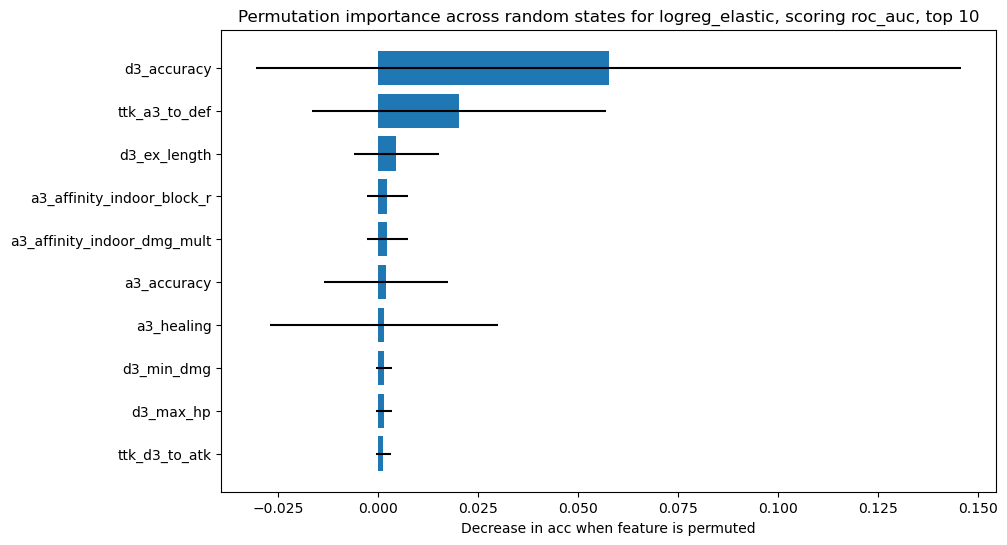

In [129]:
p = Path("../results/grid_pipe")
model_n = "logreg_elastic"

scoring = "roc_auc"
n_repeats = 5

all_rows = []

for r in random_states:
    with open(p / f"{model_n}_seed{r}_best_pipe.pkl", "rb") as f:
        pipe = pickle.load(f)
    with open(p / f"{model_n}_seed{r}_X_test.pkl", "rb") as f:
        X_test = pickle.load(f)
    with open(p / f"{model_n}_seed{r}_y_test.pkl", "rb") as f:
        y_test = pickle.load(f)

    perm_res = permutation_importance(
        pipe,
        X_test,
        y_test,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=5)

    for feat, mean_imp, std_imp in zip(X_test.columns, perm_res.importances_mean, perm_res.importances_std):
        all_rows.append({
            "seed": r,
            "feature": feat,
            "importance": float(mean_imp),
            "importance_std": float(std_imp)})

imp_df = pd.DataFrame(all_rows)

# aggregate across seeds
imp_summary = (imp_df.groupby("feature")["importance"].agg(mean="mean", std="std")
               .sort_values("mean", ascending=False).reset_index())

display(imp_summary.head(10))

# plot topk
k = 10
top = imp_summary.head(k).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["mean"], xerr=top["std"])
plt.title(f"Permutation importance across random states for {model_n}, scoring {scoring}, top {k}")
plt.xlabel("Decrease in acc when feature is permuted")
plt.show()


<h3>Linear model feature weights</h3>

In [29]:
# group utilities
def strip_transformer(name: str) -> str:
    s = name.split("__", 1)[1] if "__" in name else name
    return s.split("=", 1)[0]

def to_family(name: str) -> str:
    s = strip_transformer(name)
    return s.split("_", 1)[0]

def to_stat_type(name: str) -> str:
    s = strip_transformer(name)
    return s.rsplit("_", 1)[-1] if "_" in s else s

In [30]:
# extract coef from fitted pipe
def get_coef_importance_df(pipe, class_index=0):
    clf = pipe.named_steps.get("clf", None) or pipe[-1]
    pre = pipe.named_steps.get("prep", None) or pipe[0]

    feat_names = pre.get_feature_names_out()
    coefs = clf.coef_
    
    # binary or multiclass
    if coefs.ndim == 2 and coefs.shape[0] > 1:
        coef_vec = coefs[class_index]
    else:
        coef_vec = coefs.ravel()

    return (pd.DataFrame({
        "feature_transformed": feat_names,
        "coef": coef_vec,
        "abs_coef": np.abs(coef_vec),
    }).sort_values("abs_coef", ascending=False))

p = Path("../results/grid_pipe")
model_n = "logreg_elastic"
random_states = [0, 1, 2, 3, 5]

all_rows = []
for r in random_states:
    with open(p / f"{model_n}_seed{r}_best_pipe.pkl", "rb") as f:
        pipe = pickle.load(f)

    w = get_coef_importance_df(pipe)
    w["seed"] = r
    w["family"] = w["feature_transformed"].map(to_family)
    w["stat_type"] = w["feature_transformed"].map(to_stat_type)
    all_rows.append(w)

w_df = pd.concat(all_rows, ignore_index=True)

# per transformed feature
w_summary = (w_df.groupby("feature_transformed")["abs_coef"]
             .agg(mean="mean", std="std").sort_values("mean", ascending=False).reset_index())

display(w_summary.head(5))

# per family
w_family = (w_df.groupby(["seed","family"])["abs_coef"].sum().reset_index()
            .groupby("family")["abs_coef"].agg(mean="mean", std="std")
            .sort_values("mean", ascending=False).reset_index())

display(w_family.head(5))

# per stat type
w_type = (w_df.groupby(["seed","stat_type"])["abs_coef"].sum().reset_index()
          .groupby("stat_type")["abs_coef"].agg(mean="mean", std="std")
          .sort_values("mean", ascending=False).reset_index())

display(w_type.head(5))

,feature_transformed,mean,std
0,num__d3_accuracy,0.154535,0.108680
1,num__ttk_a3_to_def,0.091242,0.050317
2,num__a3_accuracy,0.044918,0.044189
3,num__a3_healing,0.041098,0.034736
4,num__d3_evasion,0.037939,0.018236


,family,mean,std
0,d3,0.245734,0.078649
1,a3,0.111635,0.011652
2,ttk,0.100825,0.038181
3,a2,0.012422,0.015854
4,d2,0.011154,0.024921


,stat_type,mean,std
0,accuracy,0.199454,0.141233
1,def,0.091242,0.050317
2,evasion,0.041839,0.020197
3,healing,0.041177,0.034673
4,length,0.038407,0.033457


In [33]:
# do a global shap
def shap_global_linear(pipe, X, max_background=200):
    clf = pipe.named_steps["clf"]
    pre = pipe.named_steps["prep"]

    Xtr = pre.transform(X)
    feat_names = pre.get_feature_names_out()

    bg = Xtr[:max_background]

    explainer = shap.LinearExplainer(clf, bg)
    sv = explainer.shap_values(Xtr)

    mean_abs = np.mean(np.abs(sv), axis=0)

    df = (pd.DataFrame({"feature_transformed": feat_names, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False))

    return df

p = Path("../results/grid_pipe")
model_n = "logreg_elastic"
random_states = [0,1,2,3,5]

rows = []
for r in random_states:
    with open(p / f"{model_n}_seed{r}_best_pipe.pkl", "rb") as f:
        pipe = pickle.load(f)
    with open(p / f"{model_n}_seed{r}_X_test.pkl", "rb") as f:
        X_test = pickle.load(f)

    s = shap_global_linear(pipe, X_test)
    s["seed"] = r
    s["family"] = s["feature_transformed"].map(to_family)
    s["stat_type"] = s["feature_transformed"].map(to_stat_type)
    rows.append(s)

shap_df = pd.concat(rows, ignore_index=True)

# per transformed feature
shap_global_summary = (shap_df.groupby("feature_transformed")["mean_abs_shap"]
                       .agg(mean="mean", std="std")
                       .sort_values("mean", ascending=False).reset_index())

display(shap_global_summary.head(5))

# per family
shap_family = (shap_df.groupby(["seed","family"])["mean_abs_shap"].sum().reset_index()
               .groupby("family")["mean_abs_shap"].agg(mean="mean", std="std")
               .sort_values("mean", ascending=False).reset_index())

display(shap_family.head(5))

# per stat type
shap_type = (shap_df.groupby(["seed","stat_type"])["mean_abs_shap"].sum().reset_index()
             .groupby("stat_type")["mean_abs_shap"].agg(mean="mean", std="std")
             .sort_values("mean", ascending=False).reset_index())

display(shap_type.head(5))


,feature_transformed,mean,std
0,num__d3_accuracy,0.134226,0.101765
1,num__ttk_a3_to_def,0.063133,0.031734
2,num__a3_healing,0.037380,0.037697
3,num__a3_accuracy,0.034669,0.032547
4,num__d3_evasion,0.032763,0.020074


,family,mean,std
0,d3,0.210864,0.066257
1,a3,0.095345,0.018335
2,ttk,0.070399,0.022392
3,a2,0.012135,0.015687
4,d2,0.008223,0.018376


,stat_type,mean,std
0,accuracy,0.168895,0.125847
1,def,0.063133,0.031734
2,healing,0.037445,0.037646
3,evasion,0.036447,0.021212
4,length,0.032385,0.025551


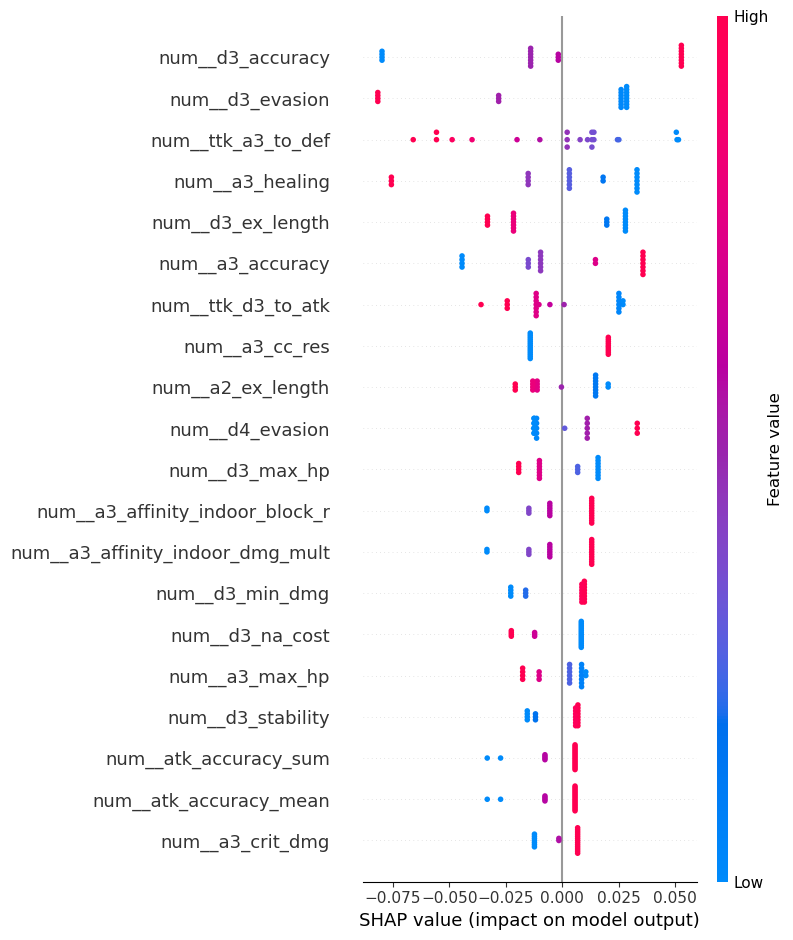

In [46]:
# shap plot for one seed = 0

rs=0

with open(p / f"{model_n}_seed{rs}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)
with open(p / f"{model_n}_seed{rs}_X_test.pkl", "rb") as f: X_test = pickle.load(f)

clf = pipe.named_steps["clf"]; pre = pipe.named_steps["prep"]

Xtr = pre.transform(X_test)
feature_names = pre.get_feature_names_out()

bg = Xtr[:200]; Xplot = Xtr[:1000]

explainer = shap.LinearExplainer(clf, bg); sv = explainer.shap_values(Xplot)
shap.summary_plot(sv, Xplot, feature_names=feature_names)


# Local Feature Importances

<h3>Local SHAP</h3>

In [74]:
indices = [0,1,2,3,4,5]

# baseline
base = explainer.expected_value
print(base)

# loop and see local point explanations
for index in indices:
    sv_row = sv[index,:]
    x_row  = Xplot[index,:]
    
    print("og row id:", X_test.index[index])
    display(shap.force_plot(base, sv_row, features=x_row, feature_names=feature_names))



-0.043447353262623827
og row id: 135


og row id: 144


og row id: 60


og row id: 101


og row id: 143


og row id: 88
